In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split


def get_dataset():
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
    device = torch.device('cpu')


    df_train = pd.read_csv(r"/kaggle/input/dataset/dataset/train_FD001.txt", sep = ' ', header = None)
    df_test = pd.read_csv(r"/kaggle/input/dataset/dataset/test_FD001.txt", sep = ' ', header = None)
    df_RUL = pd.read_csv(r"/kaggle/input/dataset/dataset/RUL_FD001.txt", header = None)

    df_train = df_train[list(range(26))]
    df_train.columns = col_list
    df_train = df_train[new_col_list]

    df_test = df_test[list(range(26))]
    df_test.columns = col_list
    df_test = df_test[new_col_list]

    scale_col_list = new_col_list[2:]
    df_train[scale_col_list] = minmax_scale(df_train[scale_col_list])
    df_test[scale_col_list] = minmax_scale(df_test[scale_col_list])

   

    seq_selected = min(df_test.groupby('unit').max()['time'])
    max_list = list(df_train.groupby('unit').max()['time']) 


    i = 0
    X_train = Variable(torch.Tensor([]).float()).to(device)
    for item in max_list:
        temp_list = Variable(torch.Tensor([]).float()).to(device)
        for j in range(item - seq_selected):
            zero_list = Variable(torch.Tensor(df_train.values[i+j:i+j+seq_selected, 2:]).float()).to(device)
            # temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
            temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 17)), dim=0)
        i += item
        X_train = torch.cat((X_train, temp_list), dim=0)

    print("The shape of input data for training model, X_train is", X_train.shape)

    y_train = []
    for item in max_list:
        y_train.extend(list(range(item-seq_selected))[::-1])
    y_train.extend(i if i<125 else 125 for i in list(range(item-seq_selected))[::-1])
    y_train = Variable(torch.Tensor(y_train).float()).to(device)

    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train before view: {y_train.shape}")
    y_train = y_train[:X_train.shape[0]]
    y_train = y_train.view(X_train.shape[0], 1)


    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    print("The shape of input data for training model, X_train is", X_train.shape)
    print("The shape of input data for training model, y_train is", y_train.shape)
    print("The shape of input data for validation model, X_val is", X_val.shape)
    print("The shape of input data for validation model, y_val is", y_val.shape)

    max_list_test = list(df_test.groupby('unit').max()['time'])
    i = 0
    input_size = 17
    X_test = Variable(torch.Tensor([]).float()).to(device)
    for item in max_list_test:
        temp_list = Variable(torch.Tensor([]).float()).to(device)
        zero_list = Variable(torch.Tensor(df_test.values[i + item - seq_selected : i + item, 2:]).float()).to(device)
        # temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
        temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, input_size)), dim=0)
        i += item
        X_test = torch.cat((X_test, temp_list), dim=0)
    print("The shape of input data for testing model, X_test is", X_test.shape)
    y_test = df_RUL.values
    # clip them to 125
    y_test = np.clip(y_test, 0, 125)
    y_test = Variable(torch.Tensor(y_test).float()).to(device)
    print("The shape of input data for testing model, y_test is", y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test, seq_selected


X_train, y_train, X_val, y_val, X_test, y_test, seq_selected = get_dataset()

The shape of input data for training model, X_train is torch.Size([17531, 31, 17])
Shape of X_train: torch.Size([17531, 31, 17])
Shape of y_train before view: torch.Size([17700])
The shape of input data for training model, X_train is torch.Size([14024, 31, 17])
The shape of input data for training model, y_train is torch.Size([14024, 1])
The shape of input data for validation model, X_val is torch.Size([3507, 31, 17])
The shape of input data for validation model, y_val is torch.Size([3507, 1])
The shape of input data for testing model, X_test is torch.Size([100, 31, 17])
The shape of input data for testing model, y_test is torch.Size([100, 1])


In [2]:
num_epochs = 35
batch_size = 256
hidden_size = 50
hidden_dim2 = 25
input_size = 17

In [4]:
device = torch.device("cuda")

In [5]:
import torch.nn as nn
class BDLSTM(nn.Module):  
    def __init__(self,hidden_size=50):
        super(BDLSTM, self).__init__()
        self.hidden_size=hidden_size
        self.lstm = nn.LSTM(batch_first=True, input_size=input_size, hidden_size=50, num_layers=1,bidirectional=True)
        self.attenion = Attention3dBlock()
        self.linear = nn.Sequential(
            nn.Linear(in_features=seq_selected*self.hidden_size*2, out_features=50),
            nn.ReLU(inplace=True),
           # nn.Dropout(p=0.5),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(inplace=True)
        )
        self.mslinear = nn.Sequential(
            nn.Linear(in_features=input_size*2, out_features=10),
            nn.ReLU(inplace=True),
           # nn.Dropout(p=0.5)
        )

        self.output = nn.Sequential(
            # nn.Linear(in_features=10, out_features=1)
            nn.Linear(in_features=20, out_features=1)
        )

    def forward(self, inputs):#256,31,17
        mean=torch.mean(inputs,dim=1)#256,17
        std=torch.std(inputs,dim=1)#256,17
        mean_std_feature=torch.concat((mean,std),dim=1)#256,34
        y = self.mslinear(mean_std_feature)
        x, (hn, cn) = self.lstm(inputs)#256,31,50
        x = self.attenion(x)#256, 31, 50
        # flatten
        x = x.reshape(-1, seq_selected*self.hidden_size*2)#256, 1550
        x = self.linear(x)#256, 10
        out = torch.concat((x, y), dim=1)
        # out=x
        out = self.output(out)
        return out


class Attention3dBlock(nn.Module):
    def __init__(self):
        super(Attention3dBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=seq_selected, out_features=seq_selected),
            nn.Softmax(dim=2),
        )

    # inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output
torch.manual_seed(114514)
model=BDLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
savepth="bdlstm"

In [6]:
import matplotlib.pyplot as plt

Epoch 0, Train Loss: 4958.3672, Val Loss: 3680.0979, Val R2: -0.0025
Epoch 1, Train Loss: 4952.7578, Val Loss: 3672.8433, Val R2: -0.0005
Epoch 2, Train Loss: 4945.7700, Val Loss: 3665.6331, Val R2: 0.0014
Epoch 3, Train Loss: 4937.3115, Val Loss: 3657.4768, Val R2: 0.0037
Epoch 4, Train Loss: 4925.6958, Val Loss: 3646.7795, Val R2: 0.0066
Epoch 5, Train Loss: 4893.3311, Val Loss: 3621.3875, Val R2: 0.0135
Epoch 6, Train Loss: 4685.3120, Val Loss: 3447.4861, Val R2: 0.0609
Epoch 7, Train Loss: 2349.8831, Val Loss: 1620.7643, Val R2: 0.5585
Epoch 8, Train Loss: 1747.5421, Val Loss: 1401.5007, Val R2: 0.6182
Epoch 9, Train Loss: 1715.2983, Val Loss: 1352.0698, Val R2: 0.6317
Epoch 10, Train Loss: 1638.6127, Val Loss: 1325.6382, Val R2: 0.6389
Epoch 11, Train Loss: 1618.5775, Val Loss: 1305.7572, Val R2: 0.6443
Epoch 12, Train Loss: 1543.7603, Val Loss: 1276.4939, Val R2: 0.6523
Epoch 13, Train Loss: 1529.5831, Val Loss: 1192.4238, Val R2: 0.6752
Epoch 14, Train Loss: 1444.7737, Val Loss:

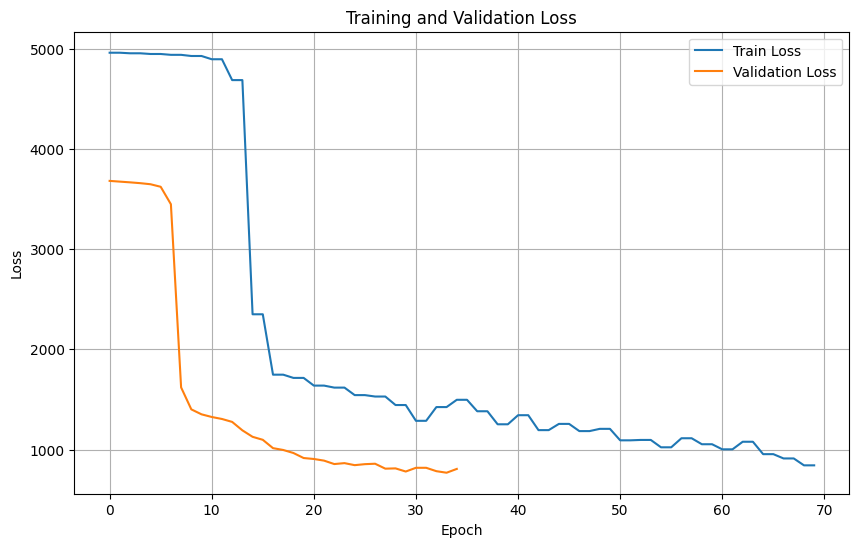

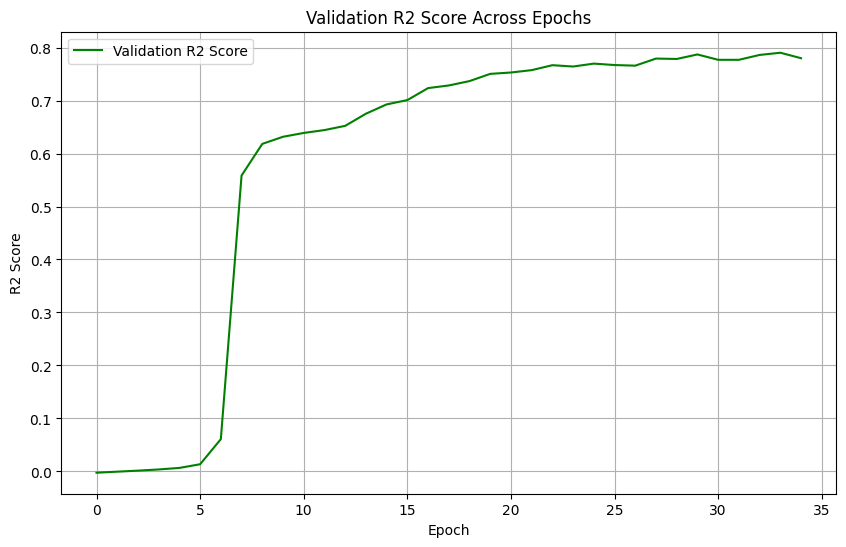

In [9]:
from sklearn.metrics import r2_score
train_loss = []
val_losses = []
val_r2_scores = []
for epoch in range(num_epochs):   
    model.train()
    val_predictions_list = []
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        indices = range(i, min(i+batch_size, len(X_train)))
        X_batch = X_train[indices].to(device)
        out = model(X_batch)
        loss = criterion(out, y_train[indices].to(device))        
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to(device)).cpu().numpy()
        val_targets = y_val.cpu().numpy()
        val_loss = criterion(torch.tensor(val_outputs), torch.tensor(val_targets)).item()
        
        # Validation R2 score
        val_r2 = r2_score(val_targets, val_outputs)
        val_r2_scores.append(val_r2)
    
    train_loss.append(loss.item())
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}")

    model.train()  # Switch back to training mode

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the R2 scores
plt.figure(figsize=(10, 6))
plt.plot(val_r2_scores, label='Validation R2 Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Validation R2 Score Across Epochs')
plt.legend()
plt.grid()
plt.show()

Test Loss: 1226.7676
RMSE on Test Set: 35.0252
R2 Score on Test Set: 0.2361


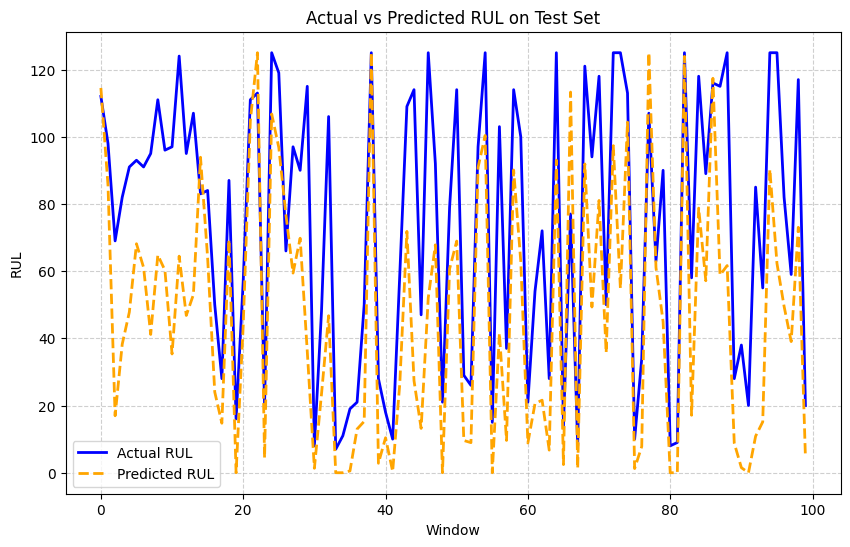

In [10]:
model.eval()    
test_predictions = model(X_test.to(device))
test_predictions = torch.clamp(test_predictions, 0, 125)
test_loss = criterion(test_predictions, y_test.to(device)).item()

with torch.no_grad():
    test_predictions = model(X_test.to(device))
    test_predictions = torch.clamp(test_predictions, 0, 125)

    test_loss = criterion(test_predictions, y_test.to(device)).item()
    print(f'Test Loss: {test_loss:.4f}')
    print(f"RMSE on Test Set: {test_loss**0.5:.4f}")

    test_predictions = test_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    
    test_r2 = r2_score(y_test_np, test_predictions)
    print(f"R2 Score on Test Set: {test_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label='Actual RUL', color='blue', linewidth=2)
plt.plot(test_predictions, label='Predicted RUL', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Window')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL on Test Set')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()